In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
import yfinance
import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('data\df.csv',sep='|')
data['date'] = pd.to_datetime(data['date'])

DXY = yfinance.download('DX-Y.NYB', start='1999-01-04', end='2025-09-19')
DXY = DXY.reset_index()[['Date','Close']]
DXY.columns = ['date','DXY']
data=data.merge(DXY, on='date', how='left')

GDPM = pd.read_csv('GDP Monthly.csv',sep=',')
GDPM['date'] = pd.to_datetime(GDPM['timestamp'])
GDPM['year'] = GDPM['date'].dt.year
GDPM['month'] = GDPM['date'].dt.month
GDPM['CroissM'] = GDPM['EIA/GDPQXUS/USA'].diff()

data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month

data = data.merge(GDPM, on=['year', 'month'], how='left')
data.drop(['timestamp','date_y','year','month'], axis=1, inplace=True)
data['DXY'].fillna(method='ffill', inplace=True)
print(data.columns)
data.set_index('date_x', inplace=True)

<>:13: SyntaxWarning: invalid escape sequence '\d'
<>:13: SyntaxWarning: invalid escape sequence '\d'
C:\Users\HOME\AppData\Local\Temp\ipykernel_10268\3348451421.py:13: SyntaxWarning: invalid escape sequence '\d'
  data = pd.read_csv('data\df.csv',sep='|')
[*********************100%***********************]  1 of 1 completed

Index(['date_x', 'close', 'volume', 'high', 'low', 'pe',
       'num_daily_adv_minus_decl', 'mov_avg_20d', 'best_eps', 'dvd_sh_last',
       'rsi_3d', 'rsi_9d', 'rsi_14d', 'rsi_30d', 'mov_avg_10d', 'mov_avg_30d',
       'mov_avg_50d', 'pb', 'pib_pct', 'pib', 'vix', 'i', 'i_future',
       'inflation', 'gold', 'gold_pct', 'gold_volume', 'brent', 'brent_pct',
       'brent_volume', 'cible', 'returns', 'vol', 'score', 'momentum_10d',
       'macd', 'macd_signal', 'bb_upper', 'bb_lower', 'mov_avg_100d',
       'mov_avg_200d', 'mov_avg_10_50_diff', 'mov_avg_20_50_diff',
       'close_minus_10d', 'close_minus_20d', 'close_minus_30d',
       'close_minus_50d', 'close_minus_100d', 'close_minus_200d', 'DXY',
       'EIA/GDPQXUS/USA', 'CroissM'],
      dtype='object')


  RANDOM FOREST - PRÉDICTION DU PRIX S&P 500
Target créée: Prix dans 1 jour(s)

🌲 Entraînement Random Forest Regressor...
  - Nombre d'arbres: 100
  - Profondeur max: 15
  - Min samples split: 20
Modèle entraîné avec succès!
VALIDATION DU MODÈLE
DONNÉES D'ENTRAÎNEMENT (5333 obs)
  MAE:  7.89 points
  RMSE: 14.07 points
  R²:   0.9995
DONNÉES DE TEST (1334 obs)
  MAE:  26.86 points
  RMSE: 38.94 points
  R²:   0.9979
  MAPE: 0.60%


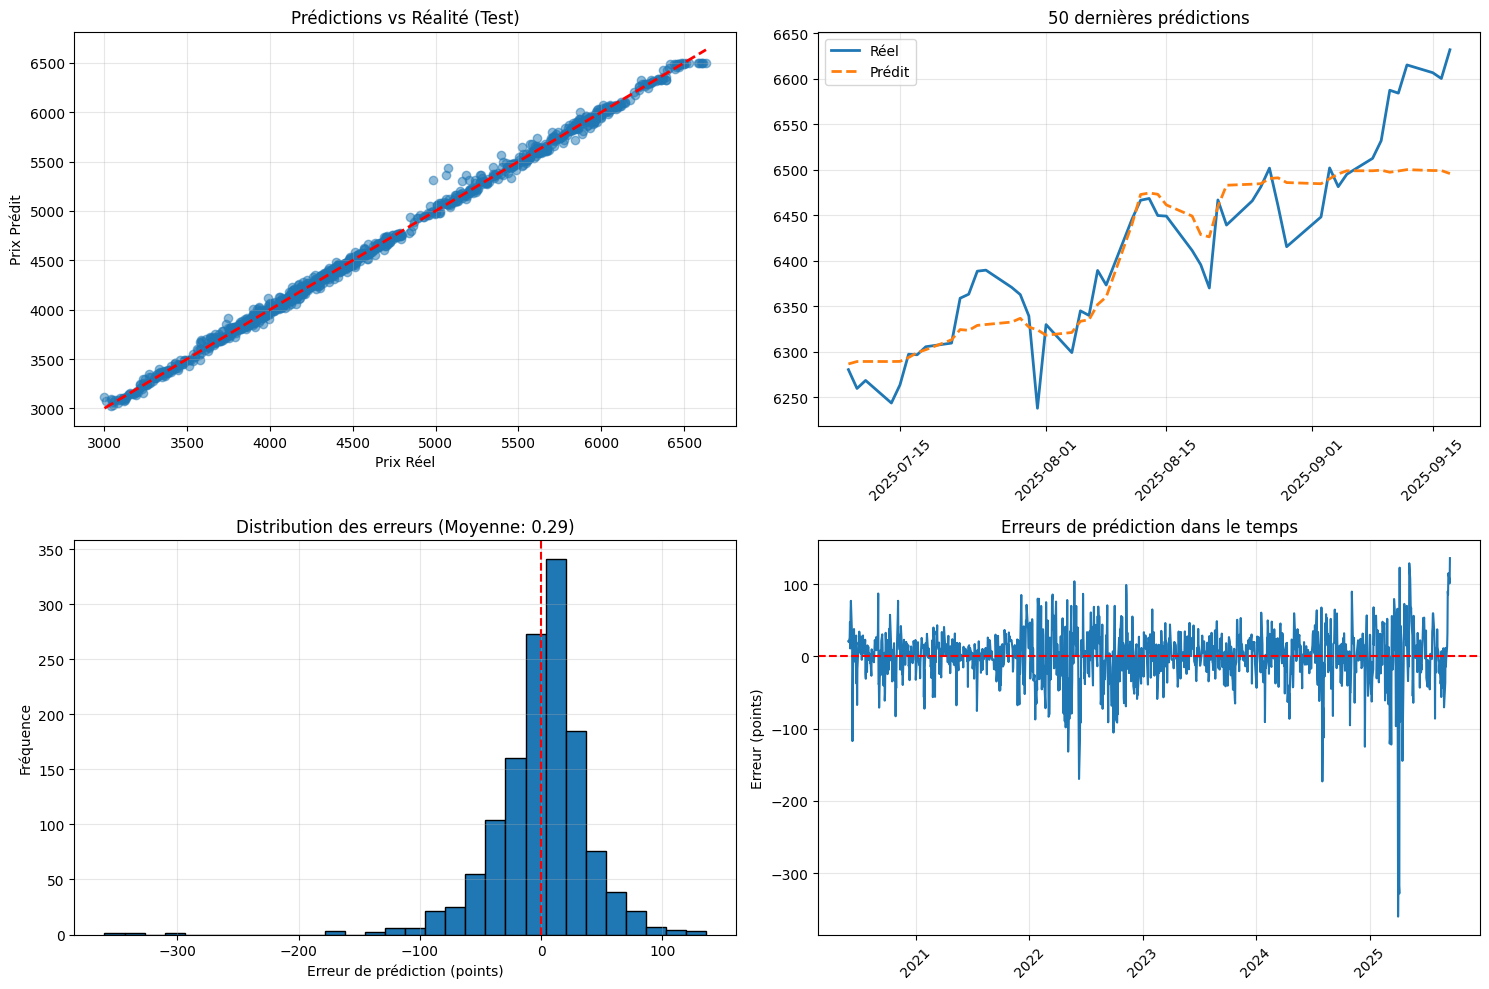

 TOP 15 FEATURES LES PLUS IMPORTANTES
ma_10                          0.0691
cible_lag_1                    0.0549
low                            0.0453
target_lag_1                   0.0425
price_lag_2_lag_1              0.0425
cible_lag_1_lag_1              0.0410
ma_5_lag_1_lag_1               0.0347
ma_5_lag_1                     0.0334
high                           0.0323
price_lag_2                    0.0316
ma_5                           0.0312
price_lag_1_lag_1              0.0301
cible                          0.0260
high_lag_1                     0.0215
high_lag_1_lag_1               0.0208


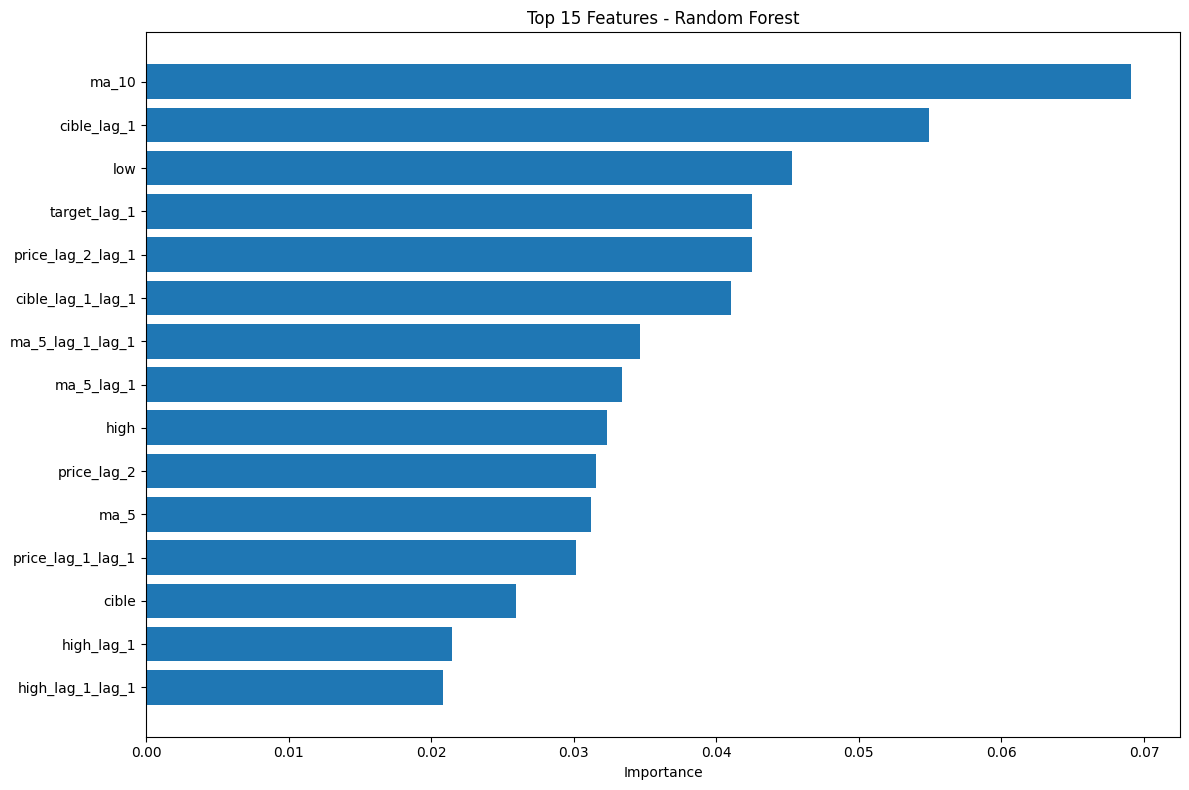

 PRÉDICTIONS DU PRIX FUTUR
2025-09-04: Prédit=6495.55, Réel=6481.50, Erreur=+14.05
2025-09-05: Prédit=6498.95, Réel=6495.15, Erreur=+3.80
2025-09-08: Prédit=6498.99, Réel=6512.61, Erreur=-13.62
2025-09-09: Prédit=6499.64, Réel=6532.04, Erreur=-32.40
2025-09-10: Prédit=6497.38, Réel=6587.47, Erreur=-90.09
2025-09-11: Prédit=6498.75, Réel=6584.29, Erreur=-85.54
2025-09-12: Prédit=6500.22, Réel=6615.28, Erreur=-115.06
2025-09-15: Prédit=6499.24, Réel=6606.76, Erreur=-107.52
2025-09-16: Prédit=6499.24, Réel=6600.35, Erreur=-101.11
2025-09-17: Prédit=6495.91, Réel=6631.96, Erreur=-136.05

💡 PRÉDICTION LA PLUS RÉCENTE: 6495.91 $


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

class SP500RandomForestRegressor:
    """
    Random Forest pour prédire le PRIX FUTUR du S&P 500
    """
    
    def __init__(self):
        self.model = None
        self.data = None
        self.X = None
        self.y = None
        self.feature_names = []
        self.is_fitted = False
        
    def load_and_prepare_data(self, file_path, target_column='close', forecast_horizon=1):
        """
        Charge et prépare les données pour prédire le prix futur
        
        Parameters:
        -----------
        file_path : str
            Chemin vers le fichier Excel
        target_column : str
            Colonne contenant les prix du S&P 500
        forecast_horizon : int
            Nombre de jours à l'avance à prédire (1 = demain, 5 = dans 5 jours)
        """
        # Charger les données
        df = data
        
        # Gérer l'index temporel
        date_cols = [col for col in df.columns if 'date' in col.lower() or 'time' in col.lower()]
        if date_cols:
            df[date_cols[0]] = pd.to_datetime(df[date_cols[0]])
            df.set_index(date_cols[0], inplace=True)
            df = df.sort_index()
        
        self.data = df.copy()
        
        # Créer les features
        df = self._create_temporal_features(df, target_column)
        
        # IMPORTANT : Créer la variable cible = PRIX FUTUR
        df['target'] = df[target_column].shift(-forecast_horizon)
        
        print(f"Target créée: Prix dans {forecast_horizon} jour(s)")
        
        # Sélectionner les features (exclure le prix actuel pour éviter le data leakage)
        exclude_cols = [target_column, 'target', 'Open', 'High', 'Low', 'close']
        feature_cols = [col for col in df.columns 
                       if col not in exclude_cols 
                       and df[col].dtype in ['int64', 'float64', 'bool']]
        
        # Supprimer les lignes avec NaN
        df_clean = df[feature_cols + ['target']].dropna()
        
        self.X = df_clean[feature_cols]
        self.y = df_clean['target']
        self.feature_names = feature_cols
        
        return self.X, self.y
    
    def _create_temporal_features(self, df, target_column):
        """
        Crée des features à partir de l'historique des prix
        """
        # 1. Lags de prix (valeurs passées)
        for lag in [1, 2, 3, 5, 10]:
            df[f'price_lag_{lag}'] = df[target_column].shift(lag)
        
        # 2. Rendements passés
        df['return_1d'] = df[target_column].pct_change()
        df['return_2d'] = df[target_column].pct_change(2)
        df['return_5d'] = df[target_column].pct_change(5)
        df['return_10d'] = df[target_column].pct_change(10)
        
        # 3. Moyennes mobiles
        for window in [5, 10, 20, 50]:
            df[f'ma_{window}'] = df[target_column].rolling(window).mean()
            df[f'price_vs_ma_{window}'] = (df[target_column] - df[f'ma_{window}']) / df[f'ma_{window}']
        
        # 4. Volatilité
        df['volatility_5d'] = df['return_1d'].rolling(5).std()
        df['volatility_10d'] = df['return_1d'].rolling(10).std()
        df['volatility_20d'] = df['return_1d'].rolling(20).std()
        
        # 5. Momentum
        df['momentum_5d'] = df[target_column] / df[target_column].shift(5) - 1
        df['momentum_10d'] = df[target_column] / df[target_column].shift(10) - 1
        
        # 6. RSI (Relative Strength Index)
        delta = df[target_column].diff()
        gain = (delta.where(delta > 0, 0)).rolling(14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
        rs = gain / loss
        df['rsi'] = 100 - (100 / (1 + rs))
        
        # 7. Features OHLC (si disponibles)
        if all(col in df.columns for col in ['Open', 'High', 'Low', 'close']):
            df['daily_range'] = (df['High'] - df['Low']) / df['close']
            df['body'] = (df['close'] - df['Open']) / df['close']
            df['upper_shadow'] = (df['High'] - df[['Open', 'close']].max(axis=1)) / df['close']
            df['lower_shadow'] = (df[['Open', 'close']].min(axis=1) - df['Low']) / df['close']
        
        # 8. Volume (si disponible)
        if 'Volume' in df.columns:
            df['volume_ma_20'] = df['Volume'].rolling(20).mean()
            df['volume_ratio'] = df['Volume'] / df['volume_ma_20']
        
        # 10. VIX ou autres variables (si disponibles)
        for col in df.columns:
            if col not in [target_column, 'Open', 'High', 'Low', 'close', 'Volume']:
                if df[col].dtype in ['float64', 'int64']:
                    df[f'{col}_lag_1'] = df[col].shift(1)
                    df[f'{col}_change'] = df[col].diff()
        
        return df
    
    def fit_random_forest(self, n_estimators=100, max_depth=15, min_samples_split=20):
        """
        Entraîne le modèle Random Forest
        """
        if self.X is None or self.y is None:
            raise ValueError("Données non préparées. Utilisez load_and_prepare_data() d'abord.")
        
        print(f"\n🌲 Entraînement Random Forest Regressor...")
        print(f"  - Nombre d'arbres: {n_estimators}")
        print(f"  - Profondeur max: {max_depth}")
        print(f"  - Min samples split: {min_samples_split}")
        
        self.model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=10,
            max_features='sqrt',
            random_state=42,
            n_jobs=-1,
            verbose=0
        )
        
        self.model.fit(self.X, self.y)
        self.is_fitted = True
        
        print(f"Modèle entraîné avec succès!")
        
        return self.model
    
    def optimize_hyperparameters(self):
        """
        Optimise les hyperparamètres avec validation croisée temporelle
        """
        print("\n🔍 Optimisation des hyperparamètres (cela peut prendre du temps)...")
        
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [10, 15, 20, None],
            'min_samples_split': [20, 50, 100],
            'min_samples_leaf': [10, 20],
            'max_features': ['sqrt', 0.3, 0.5]
        }
        
        # Validation croisée temporelle (important pour séries temporelles)
        tscv = TimeSeriesSplit(n_splits=5)
        
        grid_search = GridSearchCV(
            RandomForestRegressor(random_state=42, n_jobs=-1),
            param_grid,
            cv=tscv,
            scoring='neg_mean_squared_error',
            n_jobs=-1,
            verbose=1
        )
        
        grid_search.fit(self.X, self.y)
        
        self.model = grid_search.best_estimator_
        self.is_fitted = True
        
        print(f"Meilleurs paramètres: {grid_search.best_params_}")
        print(f"Meilleur score MSE: {-grid_search.best_score_:.2f}")
        
        return self.model
    
    def validate_model(self, test_size=0.2):
        """
        Valide le modèle avec un split temporel
        """
        if not self.is_fitted:
            raise ValueError("Modèle non entraîné.")
        
        # Split temporel : les dernières données pour le test
        split_idx = int(len(self.X) * (1 - test_size))
        
        X_train, X_test = self.X.iloc[:split_idx], self.X.iloc[split_idx:]
        y_train, y_test = self.y.iloc[:split_idx], self.y.iloc[split_idx:]
        
        # Prédictions
        y_pred_train = self.model.predict(X_train)
        y_pred_test = self.model.predict(X_test)
        
        # Métriques
        print(f"VALIDATION DU MODÈLE")
        print(f"{'='*50}")
        
        print(f"DONNÉES D'ENTRAÎNEMENT ({len(X_train)} obs)")
        train_mae = mean_absolute_error(y_train, y_pred_train)
        train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
        train_r2 = r2_score(y_train, y_pred_train)
        print(f"  MAE:  {train_mae:.2f} points")
        print(f"  RMSE: {train_rmse:.2f} points")
        print(f"  R²:   {train_r2:.4f}")
        
        print(f"DONNÉES DE TEST ({len(X_test)} obs)")
        test_mae = mean_absolute_error(y_test, y_pred_test)
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
        test_r2 = r2_score(y_test, y_pred_test)
        test_mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
        
        print(f"  MAE:  {test_mae:.2f} points")
        print(f"  RMSE: {test_rmse:.2f} points")
        print(f"  R²:   {test_r2:.4f}")
        print(f"  MAPE: {test_mape:.2f}%")
        
        # Graphiques
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # 1. Prédictions vs Réel (scatter)
        axes[0, 0].scatter(y_test, y_pred_test, alpha=0.5)
        axes[0, 0].plot([y_test.min(), y_test.max()], 
                       [y_test.min(), y_test.max()], 'r--', lw=2)
        axes[0, 0].set_xlabel('Prix Réel')
        axes[0, 0].set_ylabel('Prix Prédit')
        axes[0, 0].set_title('Prédictions vs Réalité (Test)')
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. Série temporelle des prédictions
        recent_test = y_test.tail(50)
        recent_pred = pd.Series(y_pred_test, index=y_test.index).tail(50)
        axes[0, 1].plot(recent_test.index, recent_test, label='Réel', linewidth=2)
        axes[0, 1].plot(recent_pred.index, recent_pred, label='Prédit', 
                       linestyle='--', linewidth=2)
        axes[0, 1].set_title('50 dernières prédictions')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        axes[0, 1].tick_params(axis='x', rotation=45)
        
        # 3. Erreurs de prédiction
        errors = y_test - y_pred_test
        axes[1, 0].hist(errors, bins=30, edgecolor='black')
        axes[1, 0].set_xlabel('Erreur de prédiction (points)')
        axes[1, 0].set_ylabel('Fréquence')
        axes[1, 0].set_title(f'Distribution des erreurs (Moyenne: {errors.mean():.2f})')
        axes[1, 0].axvline(x=0, color='red', linestyle='--')
        axes[1, 0].grid(True, alpha=0.3)
        
        # 4. Erreurs dans le temps
        axes[1, 1].plot(y_test.index, errors)
        axes[1, 1].axhline(y=0, color='red', linestyle='--')
        axes[1, 1].set_title('Erreurs de prédiction dans le temps')
        axes[1, 1].set_ylabel('Erreur (points)')
        axes[1, 1].grid(True, alpha=0.3)
        axes[1, 1].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        return {
            'train_mae': train_mae, 'train_rmse': train_rmse, 'train_r2': train_r2,
            'test_mae': test_mae, 'test_rmse': test_rmse, 'test_r2': test_r2, 'test_mape': test_mape
        }
    
    def feature_importance(self, top_n=15):
        """
        Analyse l'importance des features
        """
        if not self.is_fitted:
            raise ValueError("Modèle non entraîné.")
        
        importance_df = pd.DataFrame({
            'feature': self.feature_names,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print(f" TOP {top_n} FEATURES LES PLUS IMPORTANTES")
        print("="*50)
        for i, row in importance_df.head(top_n).iterrows():
            print(f"{row['feature']:30s} {row['importance']:.4f}")
        
        # Graphique
        top_features = importance_df.head(top_n)
        plt.figure(figsize=(12, 8))
        plt.barh(range(len(top_features)), top_features['importance'])
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Importance')
        plt.title(f'Top {top_n} Features - Random Forest')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
        
        return importance_df
    
    def predict_future_price(self, display_last_n=10):
        """
        Prédit le prix futur avec les dernières données disponibles
        """
        if not self.is_fitted:
            raise ValueError("Modèle non entraîné.")
        
        # Utiliser les dernières observations
        last_features = self.X.iloc[-display_last_n:]
        predictions = self.model.predict(last_features)
        
        print(f" PRÉDICTIONS DU PRIX FUTUR")
        print("="*60)
        
        for i in range(len(last_features)):
            idx = last_features.index[i]
            pred_price = predictions[i]
            actual_price = self.y.loc[idx] if idx in self.y.index else None
            
            if actual_price is not None:
                error = pred_price - actual_price
                print(f"{idx.strftime('%Y-%m-%d') if hasattr(idx, 'strftime') else idx}: "
                      f"Prédit={pred_price:.2f}, Réel={actual_price:.2f}, "
                      f"Erreur={error:+.2f}")
            else:
                print(f"{idx.strftime('%Y-%m-%d') if hasattr(idx, 'strftime') else idx}: "
                      f"Prix prédit = {pred_price:.2f}")
        
        # Dernière prédiction (la plus récente)
        latest_prediction = predictions[-1]
        print(f"\n💡 PRÉDICTION LA PLUS RÉCENTE: {latest_prediction:.2f} $")
        
        return predictions

# ============================================
# EXEMPLE D'UTILISATION
# ============================================

if __name__ == "__main__":
    
    print("="*60)
    print("  RANDOM FOREST - PRÉDICTION DU PRIX S&P 500")
    print("="*60)
    
    # Créer le modèle
    rf_model = SP500RandomForestRegressor()
    
    # Charger et préparer vos données
    X, y = rf_model.load_and_prepare_data(
        data,
        target_column='close',  # ← Ajuster selon votre colonne
        forecast_horizon=1  # Prédire le prix de demain
    )
    
    
    # Entraîner le modèle
    rf_model.fit_random_forest(n_estimators=100, max_depth=15)
    
    # OU optimiser les hyperparamètres (plus lent mais meilleur)
    # rf_model.optimize_hyperparameters()
    
    # Valider le modèle
    metrics = rf_model.validate_model(test_size=0.2)
    
    # Analyser l'importance des features
    importance = rf_model.feature_importance(top_n=15)
    
    # Faire des prédictions sur les dernières données
    predictions = rf_model.predict_future_price(display_last_n=10)